## Methylation Data Preprocessing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/a-nadeem9/brca-epigenetic-age-acceleration-immune-multiomics-classifier/blob/main/notebooks/01c_methylation_preprocessing.ipynb)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import h5py

with h5py.File('../methylation_matched_final.h5', 'r') as f:
    print("Available datasets:")
    for key in f.keys():
        print(key)

Available datasets:
methylation


In [5]:
df = pd.read_hdf('../methylation_matched_final.h5', key='methylation')


In [6]:
# Display the first few rows of the dataframe
df.head()

,TCGA-C8-A27B-01A-11D-A16A-05,TCGA-E9-A3Q9-01A-11D-A21R-05,TCGA-C8-A3M8-01A-11D-A212-05,TCGA-E9-A5FL-01A-11D-A27Y-05,TCGA-A2-A25F-01A-11D-A16A-05,TCGA-A1-A0SE-01A-11D-A10P-05,TCGA-A7-A425-01A-11D-A244-05,TCGA-E9-A1N8-01A-11D-A145-05,TCGA-D8-A1X8-01A-11D-A14N-05,TCGA-E2-A3DX-01A-21D-A212-05,...,TCGA-BH-A0AZ-01A-21D-A12R-05,TCGA-AO-A0JC-01A-11D-A10P-05,TCGA-B6-A0X1-01A-11D-A10A-05,TCGA-E9-A22H-01A-11D-A161-05,TCGA-AO-A03L-01A-41D-A10P-05,TCGA-AC-A6NO-01A-12D-A33F-05,TCGA-EW-A2FS-01A-11D-A17F-05,TCGA-BH-A1FG-01A-11D-A13K-05,TCGA-LL-A7T0-01A-31D-A357-05,TCGA-V7-A7HQ-01A-11D-A33F-05
ProbeID,,,,,,,,,,,,,,,,,,,,,
cg13869341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg14008030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg12045430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg20826792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cg00381604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# FILTER PROBES by missingness 
probe_missing = df.isna().mean(axis=1) 
keep_probes = probe_missing[probe_missing <= 0.15].index
df_filt = df.loc[keep_probes]
print(f"{df_filt.shape[0]} probes remain after filtering >15% missing")

398255 probes remain after filtering >15% missing


In [8]:
# DROP sex-chromosome probes via raw GitHub manifest  
manifest_url = (
    "https://github.com/zhou-lab/InfiniumAnnotationV1/"
    "raw/main/Anno/HM450/HM450.hg38.manifest.tsv.gz"
)
# Read only the probe ID and chromosome columns from the gzipped TSV
manifest = pd.read_csv(
    manifest_url,
    sep="\t",
    compression="gzip",
    usecols=["Probe_ID", "CpG_chrm"]
)
# Standardize chromosome field
manifest["CHR"] = (
    manifest["CpG_chrm"]
    .astype(str)
    .str.replace("^chr", "", regex=True)
    .str.upper()
)
# Keep only autosomes
autos = {str(i) for i in range(1, 23)}
auto_probes = set(manifest.loc[manifest["CHR"].isin(autos), "Probe_ID"])

# Filter your already‐missingness‐filtered df_filt down to autosomal probes
df_filt = df_filt.loc[df_filt.index.intersection(auto_probes)]
print(f"{df_filt.shape[0]} autosomal probes remain")


388945 autosomal probes remain


In [ ]:
#df_filt.to_hdf('../data/methylation_matched_final_filtered.h5', key='methylation')

In [9]:
df = df_filt

In [10]:

from sklearn.impute import KNNImputer

# 3. KNN-impute the autosomal, ≤15%-missing probes
imputer = KNNImputer(n_neighbors=5)

# Transpose so samples are rows
df_T = df.T 
imp_array = imputer.fit_transform(df_T)

# Back to probes×samples with the right labels
df_imp = pd.DataFrame(
    imp_array,
    index=df_T.index, # sample IDs
    columns=df_T.columns # probe IDs
).T

print("Imputed matrix shape:", df_imp.shape,
      "— total NAs:", df_imp.isna().sum().sum())


Imputed matrix shape: (388945, 693) — total NAs: 0


### Beta value distributions

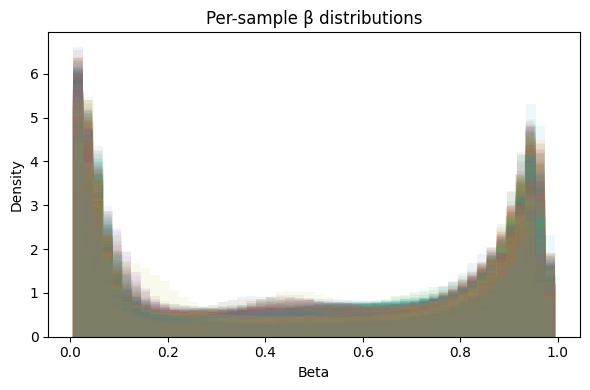

In [11]:
plt.figure(figsize=(6,4))
for s in df_imp.columns:
    plt.hist(df_imp[s].values, bins=50, alpha=0.08, density=True)
plt.xlabel("Beta")
plt.ylabel("Density")
plt.title("Per-sample β distributions")
plt.tight_layout()
plt.show()


### Heatmap of variable probes

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


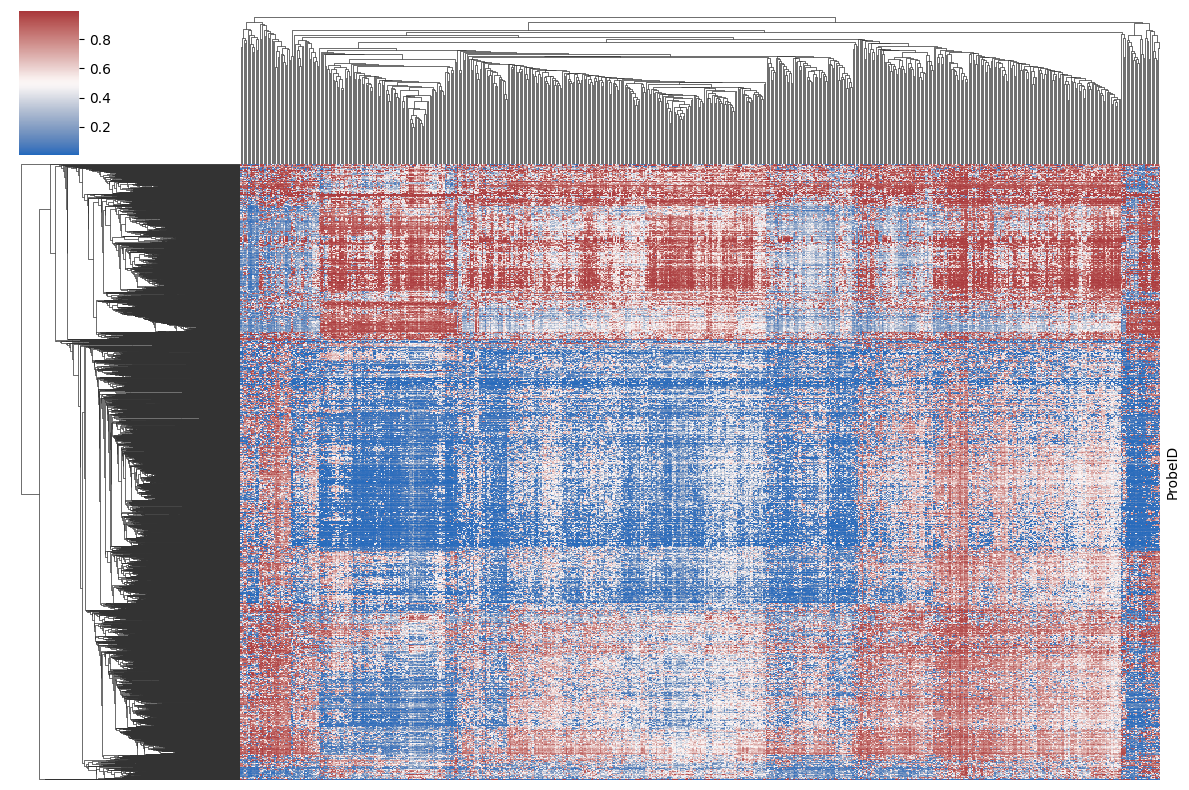

In [12]:
top_n = 5000
top_probes = df_imp.var(axis=1).sort_values(ascending=False).head(top_n).index
mat = df_imp.loc[top_probes]

import seaborn as sns
sns.clustermap(mat, cmap="vlag", col_cluster=True, row_cluster=True,
               yticklabels=False, xticklabels=False, figsize=(12,8))


In [15]:
beta = df_imp
beta = beta.clip(1e-6, 1-1e-6)
M = np.log2(beta / (1 - beta))


### Unsupervised clustering PCA

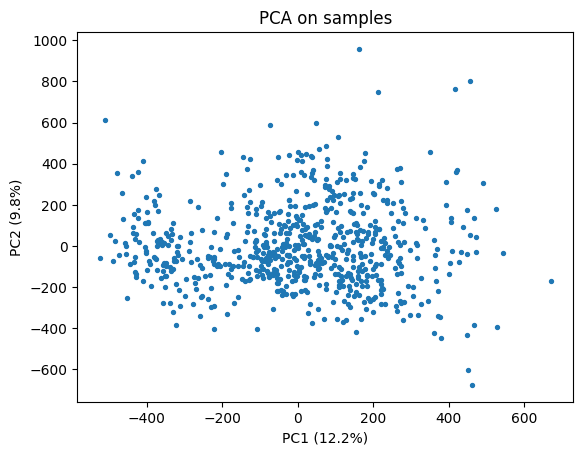

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=50, random_state=0)
X_pca = pca.fit_transform(M.T)   # samples x PCs

plt.scatter(X_pca[:,0], X_pca[:,1], s=8)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA on samples")
plt.show()


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

pcs_for_clust = X_pca[:, :20]  # first 20 PCs is usually fine
ks = range(2, 9)
scores = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=0).fit(pcs_for_clust)
    scores.append(silhouette_score(pcs_for_clust, km.labels_))

best_k = ks[int(np.argmax(scores))]
print("Best k (silhouette):", best_k)

km = KMeans(n_clusters=best_k, n_init=100, random_state=0).fit(pcs_for_clust)
clusters = pd.Series(km.labels_, index=beta.columns, name="cluster")


Best k (silhouette): 2


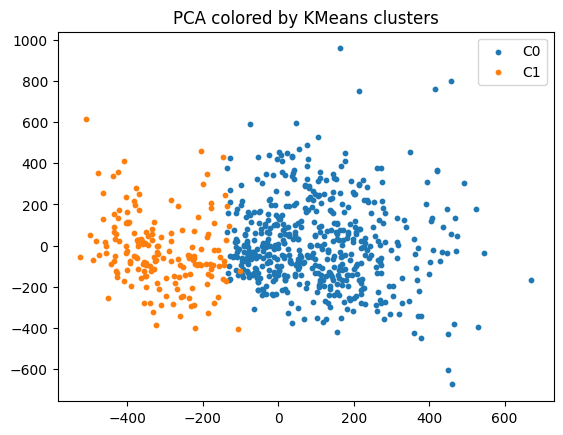

In [18]:
for c in sorted(clusters.unique()):
    idx = clusters == c
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=10, label=f"C{c}")
plt.legend()
plt.title("PCA colored by KMeans clusters")
plt.show()


### “Differential” methylation across clusters (ANOVA)

In [19]:
from scipy import stats

def anova_across_clusters(M_values, labels):
    groups = [np.where(labels == k)[0] for k in np.unique(labels)]
    pvals, fstats = np.zeros(M_values.shape[0]), np.zeros(M_values.shape[0])

    for i, probe in enumerate(M_values.index):
        vals = [M_values.iloc[i, idx].values for idx in groups]
        f, p = stats.f_oneway(*vals)
        fstats[i], pvals[i] = f, p

    # BH-FDR
    order = np.argsort(pvals)
    ranked = np.arange(1, len(pvals) + 1)
    qvals = np.empty_like(pvals, dtype=float)
    qvals[order] = np.minimum.accumulate((pvals[order[::-1]] * len(pvals) / ranked[::-1]))[::-1]
    qvals = np.minimum(qvals, 1.0)

    means = M_values.groupby(labels, axis=1).mean()
    max_diff = means.max(axis=1) - means.min(axis=1)

    res = pd.DataFrame({
        "F": fstats,
        "P.Value": pvals,
        "adj.P.Val": qvals,
        "max_mean_diff": max_diff,
        "AveExpr": M_values.mean(axis=1)
    }, index=M_values.index).sort_values("P.Value")
    return res

anova_res = anova_across_clusters(M, clusters.values)
anova_res.head()



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20160\1701213723.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  means = M_values.groupby(labels, axis=1).mean()


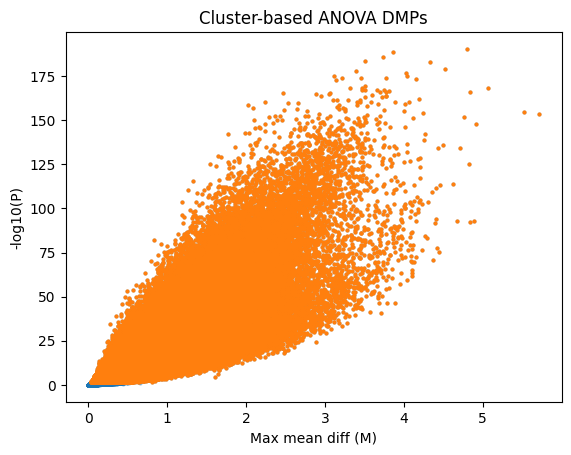

In [20]:
sig = anova_res["adj.P.Val"] < 0.05
plt.scatter(anova_res["max_mean_diff"], -np.log10(anova_res["P.Value"]), s=4, alpha=0.4)
plt.scatter(anova_res.loc[sig, "max_mean_diff"], -np.log10(anova_res.loc[sig, "P.Value"]), s=4)
plt.xlabel("Max mean diff (M)")
plt.ylabel("-log10(P)")
plt.title("Cluster-based ANOVA DMPs")
plt.show()


### Heatmap of the most cluster-informative probes

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


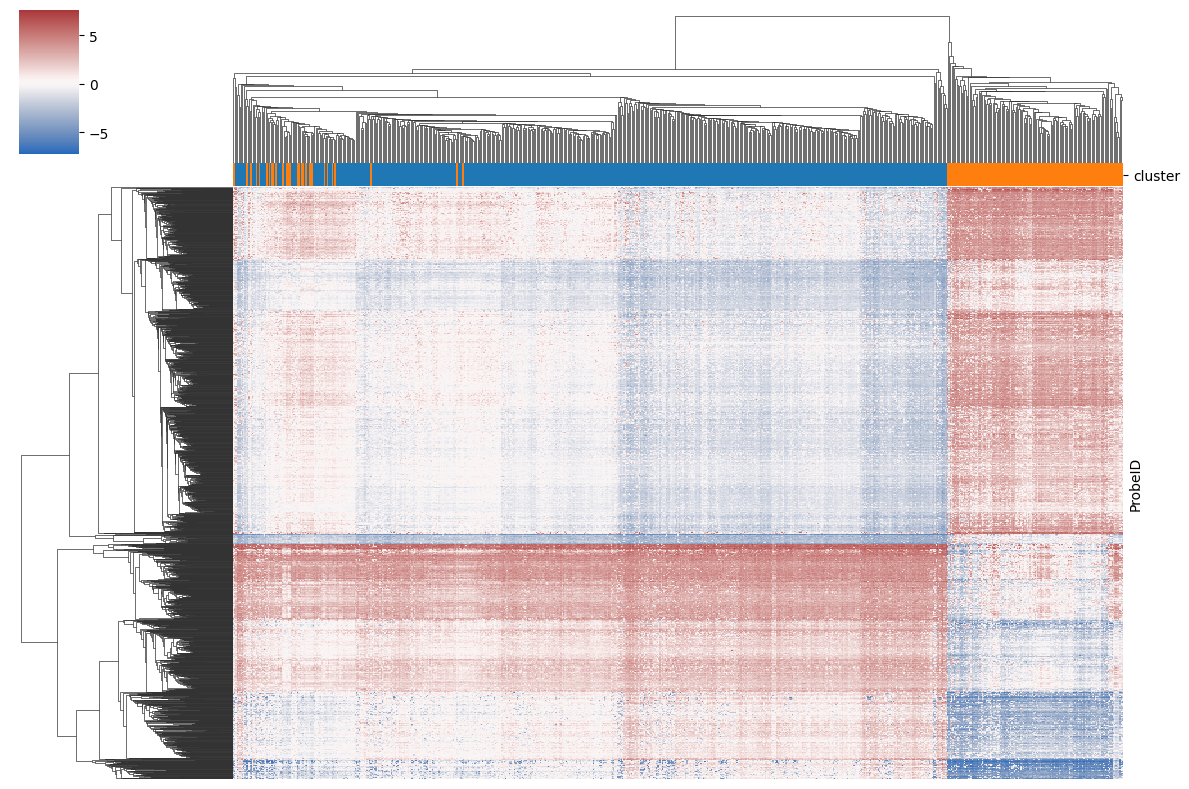

In [21]:
import seaborn as sns

top_cpgs = anova_res.nsmallest(2000, "adj.P.Val").index  # pick how many you want
sns.clustermap(M.loc[top_cpgs], col_colors=clusters.map(dict(zip(sorted(clusters.unique()), sns.color_palette("tab10", len(clusters.unique()))))),
               cmap="vlag", xticklabels=False, yticklabels=False, figsize=(12,8))
